In [1]:
import os
# Donwload key from next line link to access the buckets and requester pays requests to public bucket (this is needed to query Sentinel-2 data)
os.environ["GS_NO_SIGN_REQUEST"] = "YES"

import ee

In [4]:
# ee.Authenticate()

In [5]:
# Initialize the library.
ee.Initialize()

## Select S2 image to export

In [6]:
%%time

from shapely.geometry import box, mapping

# This is Sentinel-2 L1C.
s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')

# POI = ee.Geometry.Point([21.0503961, -3.4844154])
# geom_sample = POI.buffer(2000)

bounds = (21.032511758929683-0.01,
 -3.5024062153835964,
 21.068337134651642+0.01,
 -3.466417668097034)
geom_sample = ee.Geometry(mapping(box(*bounds)))

# Filter the collection to mid-October 2021 intersecting the Point Of Interest.
s2 = s2.filterBounds(geom_sample).filterDate('2021-10-05', '2021-10-11')

# Grab the first image in the filtered collection and select some bands
s2_image = s2.first()
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12']
s2_image = s2_image.select(*bands)

# Resample the data so that the bands all have same resolution. We'll use B2 (blue)
# for a reference projection.
s2_image = s2_image.toFloat().resample('bilinear').reproject(
    s2_image.select('B2').projection())

CPU times: user 247 ms, sys: 711 ms, total: 958 ms
Wall time: 71.6 ms


In [8]:
# https://developers.google.com/earth-engine/apidocs/ee-data-getpixels

## Export image as GeoTensor

In [6]:
%%time
from georeader.readers.ee_image import export_image_fast

data_tensor = export_image_fast(s2_image, geom_sample)
data_tensor

CPU times: user 1.29 s, sys: 178 ms, total: 1.47 s
Wall time: 8.71 s


 
         Transform: | 10.00, 0.00, 502500.00|
| 0.00,-10.00, 9616860.00|
| 0.00, 0.00, 1.00|
         Shape: (9, 399, 621)
         Resolution: (10.0, 10.0)
         Bounds: (502500.0, 9612870.0, 508710.0, 9616860.0)
         CRS: EPSG:32734
         fill_value_default: 0
        

Text(0.5, 1.0, 'GEE')

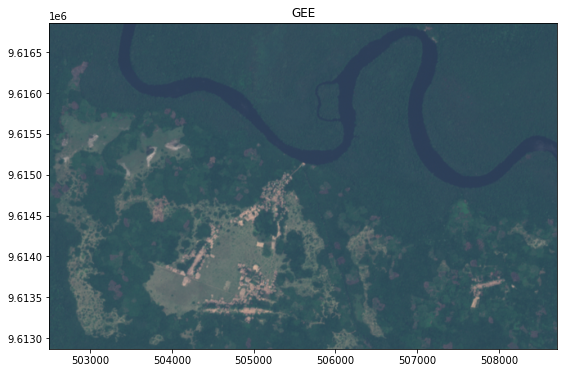

In [7]:
import rasterio.plot as rstplt
import matplotlib.pyplot as plt
import numpy as np

rgb_gee = np.clip(data_tensor.values[2::-1]/2_500,0, 1)

fig, ax = plt.subplots(1,1,figsize=(12,6))

rstplt.show(rgb_gee,ax=ax, transform=data_tensor.transform)
ax.set_title("GEE")

## Compare with image read from the bucket

In [8]:
# Get the info to find the PRODUCT_ID
info_s2_image = s2_image.getInfo()

In [9]:
%%time

from georeader.readers import S2_SAFE_reader

product_name = info_s2_image["properties"]["PRODUCT_ID"]
s2_safe_folder = S2_SAFE_reader.s2_public_bucket_path(product_name, check_exists=True)
print(f"Product {s2_safe_folder} found")
s2_obj = S2_SAFE_reader.s2loader(s2_safe_folder, out_res=10, bands=bands)
s2_obj

Product gs://gcp-public-data-sentinel-2/tiles/34/M/DB/S2B_MSIL1C_20211008T083749_N0301_R064_T34MDB_20211008T104448.SAFE found
CPU times: user 383 ms, sys: 28.3 ms, total: 411 ms
Wall time: 1.19 s


 
         gs://gcp-public-data-sentinel-2/tiles/34/M/DB/S2B_MSIL1C_20211008T083749_N0301_R064_T34MDB_20211008T104448.SAFE
         Transform: | 10.00, 0.00, 399960.00|
| 0.00,-10.00, 9700000.00|
| 0.00, 0.00, 1.00|
         Shape: (9, 10980, 10980)
         Resolution: (10.0, 10.0)
         Bounds: (399960.0, 9590200.0, 509760.0, 9700000.0)
         CRS: EPSG:32734
         bands: ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B11', 'B12']
         fill_value_default: 0
        

In [10]:
%%time
from georeader import read

data_tensor_bucket = read.read_from_polygon(s2_obj, data_tensor.footprint(), crs_polygon=data_tensor.crs, trigger_load=True)
data_tensor_bucket

CPU times: user 5.04 s, sys: 718 ms, total: 5.76 s
Wall time: 1min 8s


 
         Transform: | 10.00, 0.00, 502500.00|
| 0.00,-10.00, 9616860.00|
| 0.00, 0.00, 1.00|
         Shape: (9, 399, 621)
         Resolution: (10.0, 10.0)
         Bounds: (502500.0, 9612870.0, 508710.0, 9616860.0)
         CRS: EPSG:32734
         fill_value_default: 0
        

In [11]:
if data_tensor_bucket.transform != data_tensor.transform:
    print(f"Different crs {data_tensor_bucket.transform} {data_tensor.transform}")
else:
    print("Same transform")

if data_tensor_bucket.crs != data_tensor.crs:
    print(f"Different crs {data_tensor_bucket.crs} {data_tensor.crs}")
else:
    print("Same CRS")

if data_tensor_bucket.shape != data_tensor.shape:
    print(f"Different shape {data_tensor_bucket.shape} {data_tensor.shape}")
else:
    print("Same shape")

Same transform
Same CRS
Same shape


Text(0.5, 1.0, 'GEE')

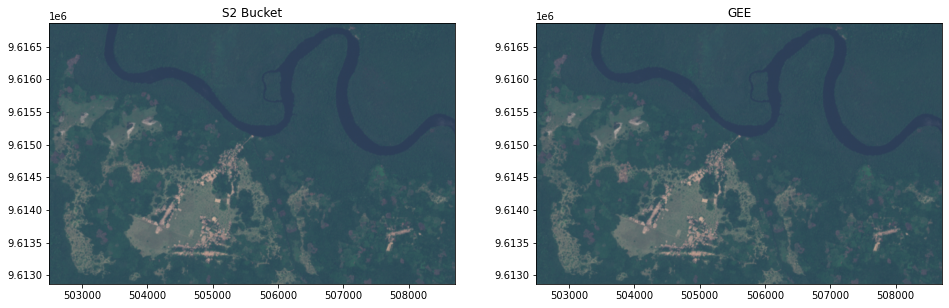

In [12]:
import rasterio.plot as rstplt
import matplotlib.pyplot as plt
import numpy as np

rgb_bucket = np.clip(data_tensor_bucket.values[2::-1]/2_500, 0, 1)
rgb_gee = np.clip(data_tensor.values[2::-1]/2_500,0, 1)

fig, ax = plt.subplots(1,2,figsize=(16,6))

rstplt.show(rgb_bucket,ax=ax[0], transform=data_tensor_bucket.transform)
ax[0].set_title("S2 Bucket")
rstplt.show(rgb_gee,ax=ax[1], transform=data_tensor.transform)
ax[1].set_title("GEE")